In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
from os import listdir

files = listdir('wind_data/')

dataset = pd.read_csv('csv/coordinates.csv')
dataset

,name,lat,long
0,S05.512_E119.406,-5.512,119.406
1,S05.512_E119.433,-5.512,119.433
2,S05.512_E119.460,-5.512,119.460
3,S05.512_E119.487,-5.512,119.487
4,S05.512_E119.514,-5.512,119.514
...,...,...,...
139,S05.809_E119.595,-5.809,119.595
140,S05.809_E119.622,-5.809,119.622
141,S05.809_E119.649,-5.809,119.649
142,S05.809_E119.676,-5.809,119.676


In [3]:
import fnmatch

wind = []
for x in dataset['name']:
    wind_data = [] 
    query = "*" + x + "*"
    yearly = fnmatch.filter(files, query)
    for year in yearly:
        windspeed = np.loadtxt(f'wind_data/{year}', skiprows=8, usecols=12, unpack=True)
        wind_data = np.append(wind_data, windspeed)
    wind.append(wind_data)
    
wind_dataset = pd.DataFrame(list(wind)).transpose()
wind_dataset

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,8.86,3.02,3.10,4.67,7.57,7.46,3.76,7.49,8.11,4.76,...,3.73,5.41,6.41,5.48,4.39,6.11,3.81,4.88,4.11,4.94
1,7.62,2.65,2.73,5.07,7.46,7.34,3.40,7.35,8.18,4.30,...,3.36,5.47,7.99,7.72,3.98,5.95,6.73,4.41,5.29,4.34
2,6.75,3.72,3.83,5.89,7.07,6.87,4.26,7.04,6.60,4.75,...,3.16,8.06,7.80,7.98,3.33,8.74,7.78,3.74,8.03,3.73
3,6.13,6.23,6.37,6.46,6.63,7.03,7.16,6.86,6.53,8.28,...,5.60,8.76,7.35,7.53,5.48,9.25,8.21,3.62,8.23,2.00
4,5.62,8.69,9.02,6.62,5.92,5.89,8.70,6.31,6.16,9.35,...,6.85,8.09,7.08,7.19,6.10,8.40,7.30,4.95,7.45,4.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105187,4.41,5.25,5.48,4.27,NaN,NaN,5.66,5.04,4.76,NaN,...,6.73,3.91,NaN,NaN,NaN,4.38,4.76,10.20,NaN,NaN
105188,4.56,5.10,6.95,5.04,NaN,NaN,7.98,6.06,4.59,NaN,...,6.57,5.15,NaN,NaN,NaN,6.23,4.38,8.60,NaN,NaN
105189,3.49,3.20,7.45,5.46,NaN,NaN,8.42,6.51,5.33,NaN,...,7.05,5.64,NaN,NaN,NaN,6.63,3.81,8.27,NaN,NaN
105190,3.23,2.64,6.12,4.93,NaN,NaN,7.05,5.70,6.07,NaN,...,6.81,4.90,NaN,NaN,NaN,5.96,3.78,8.44,NaN,NaN


**Mean Squared Error (MSE)**

MSE adalah sebuah parameter yang dapat digunakan untuk menentukan sebagaimana baik model yang dibuat dibandingkan data. Rumus MSE adalah:

$$MSE = \frac{1}{n} \sum_{n=i}^{n}{(y_{i} - \hat{y_{i}})}^2$$ 

di mana $y_{i}$ merupakan data dan $\hat{y_{i}}$ merupakan model. Dalam kasus ini model merupakan probabilitas dari distribusi weibull dengan dua parameter yaitu scale parameter dan shape parameter. Sedangkan data adalah data angin dalam bentuk distribusi probabilitas.

Nilai MSE berkisar antara $-\infty$ hingga $+\infty$ dengan nilai 0 menunjukkan tidak terdapat eror antara model dengan data.

In [4]:
from scipy.stats import weibull_min

def weibull_distribution(x, scale, shape):
    return (shape / scale) * (x / scale)**(shape - 1) * np.exp(-(x / scale)**shape)

def mse(data):
    # calculate error between weibull distribution and data in histogram with 100 bins
    
    # remove NaN values
    data = data.dropna()
    
    # calculate average speed
    windspeed_avg = data.mean()
    
    # calculate the bins of histogram 
    y, bins = np.histogram(data, density=True, bins=100)
    x = 0.5*(bins[1:]+bins[:-1]) # center bins
    
    # obtain weibull dist parameter and predict y value for each x 
    shape, loc, scale = weibull_min.fit(data, floc=0) 
    y_weibull = weibull_distribution(x, scale, shape)
    
    #calculate mse
    mse = np.square(np.subtract(y, y_weibull)).mean()
    
    return [windspeed_avg, scale, shape, mse]

In [5]:
params = []
for i in range(144):
    params.append(mse(wind_dataset[i]))

In [6]:
parameter = pd.DataFrame(params, columns=['avg', 'c', 'k', 'mse'])
dataset2 = pd.merge(dataset, parameter, left_index=True, right_index=True)
dataset2.to_csv("csv/weibull_fitting.csv")

dataset2

,name,lat,long,avg,c,k,mse
0,S05.512_E119.406,-5.512,119.406,6.458895,7.276477,2.141161,0.000175
1,S05.512_E119.433,-5.512,119.433,6.412365,7.223399,2.150409,0.000149
2,S05.512_E119.460,-5.512,119.460,6.418179,7.228854,2.166980,0.000139
3,S05.512_E119.487,-5.512,119.487,6.421796,7.231644,2.164434,0.000135
4,S05.512_E119.514,-5.512,119.514,6.412445,7.219531,2.165837,0.000143
...,...,...,...,...,...,...,...
139,S05.809_E119.595,-5.809,119.595,7.217232,8.114077,2.343465,0.000220
140,S05.809_E119.622,-5.809,119.622,7.215866,8.110314,2.362114,0.000238
141,S05.809_E119.649,-5.809,119.649,7.206370,8.097183,2.382432,0.000247
142,S05.809_E119.676,-5.809,119.676,7.116381,7.994590,2.399925,0.000288


In [7]:
wind_avg = dataset2['avg'].mean()
error_avg = dataset2['mse'].mean()

print(f'windspeed average on location is {wind_avg:.2f} m/s')
print(f'the average of mean squared error (MSE) of the weibull fitting is {error_avg:.5f}')

windspeed average on location is 7.23 m/s
the average of mean squared error (MSE) of the weibull fitting is 0.00017


In [8]:
A1_k, E4_k, I7_k = [dataset2['k'].loc[0], dataset2['k'].loc[40], dataset2['k'].loc[80]]
A1_c, E4_c, I7_c = [dataset2['c'].loc[0], dataset2['c'].loc[40], dataset2['c'].loc[80]]
A1_mse, E4_mse, I7_mse = [dataset2['mse'].loc[0], dataset2['mse'].loc[40], dataset2['mse'].loc[80]]
A1, E4, I7 = wind_dataset[0], wind_dataset[40], wind_dataset[80]

<ipython-input-9-e4b562efd1d5>:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([E4,x],


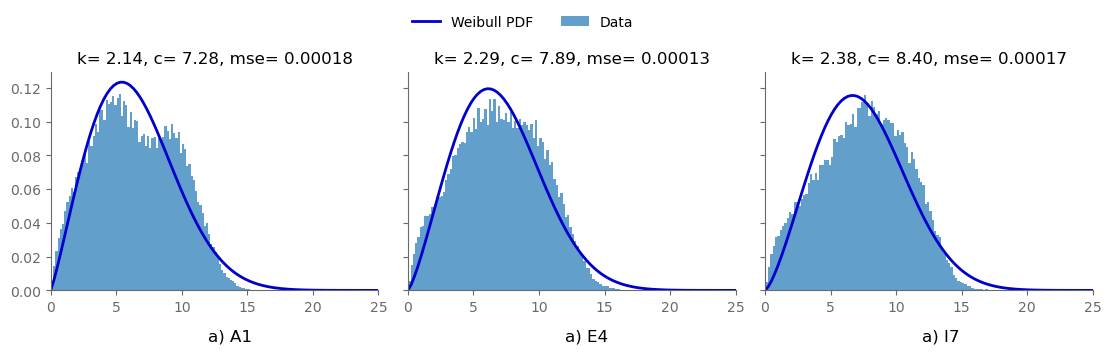

In [9]:
plt.style.use('default')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,3), constrained_layout=True, sharey=True)

x=np.linspace(0,25, 100)
    
ax1.hist(A1, bins=100, alpha=0.7, density=True, label='data')
ax1.plot(x, weibull_distribution(x, A1_c, A1_k), label='Weibull pdf', lw=2, color='mediumblue')
ax1.set_title(f"k= {A1_k:.2f}, c= {A1_c:.2f}, mse= {A1_mse:.5f}")
ax1.text(12, -0.03, 'a) A1', size=12)

ax2.hist(E4, bins=100, alpha=0.7, density=True, label='data')
ax2.plot(x, weibull_distribution(x, E4_c, E4_k), label='Weibull pdf', lw=2, color='mediumblue')
ax2.set_title(f"k= {E4_k:.2f}, c= {E4_c:.2f}, mse= {E4_mse:.5f}")
ax2.text(12, -0.03, 'a) E4', size=12)

ax3.hist(I7, bins=100, alpha=0.7, density=True, label='data')
ax3.plot(x, weibull_distribution(x, I7_c, I7_k), label='Weibull pdf', lw=2, color='mediumblue')
ax3.set_title(f"k= {I7_k:.2f}, c= {I7_c:.2f}, mse= {I7_mse:.5f}")
ax3.text(12, -0.03, 'a) I7', size=12)

for ax in ax1, ax2, ax3:
    ax.set_xlim(0,25)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('dimgray')
    ax.spines['bottom'].set_color('dimgray')
    ax.tick_params(colors='dimgray');
    
fig.legend([E4,x],
           labels=["Weibull PDF", "Data"],
           loc='upper center', bbox_to_anchor=(0.47, 1.15), ncol=2, frameon=False);

<ipython-input-4-2ad118c51271>:4: RuntimeWarning: divide by zero encountered in power
  return (shape / scale) * (x / scale)**(shape - 1) * np.exp(-(x / scale)**shape)


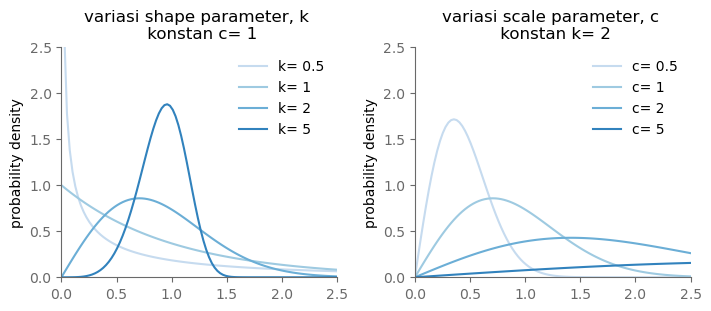

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3), constrained_layout=True)

X = np.linspace(0, 2.5, 100)
cmap = plt.cm.get_cmap('tab20c').colors[:4]

for k, color in zip([0.5, 1, 2, 5], cmap[::-1]):
    ax1.plot(X, weibull_distribution(X, 1, k), label=f'k= {k}', color=color)
    
ax1.legend(frameon=False)
ax1.set_title('variasi shape parameter, k \n konstan c= 1');

for c, color in zip([0.5, 1, 2, 5], cmap[::-1]):
    ax2.plot(X, weibull_distribution(X, c, 2), label=f'c= {c}', color=color)

ax2.legend(frameon=False)
ax2.set_title('variasi scale parameter, c \n konstan k= 2');

for ax in ax1, ax2:
    ax.set_xlim(0, 2.5)
    ax.set_ylim(0, 2.5)
    ax.set_ylabel('probability density')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('dimgray')
    ax.spines['bottom'].set_color('dimgray')
    ax.tick_params(colors='dimgray');